### This phase of the development notebook is mostly to figure out the TBC code, and refine the video RF decoding code.

In [57]:
# Just your usual setup

import numpy as np
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 
import matplotlib.pyplot as plt
import sys
import getopt

%matplotlib inline

import matplotlib
matplotlib.rc('figure', figsize=(20, 12))

from datetime import  datetime

import fft8 as fft8 
import ld_utils as utils

import copy

# for image display
from PIL import Image
from IPython.display import HTML
import IPython.display 
from io import BytesIO
from base64 import b64encode

In [58]:
pi = np.pi
tau = np.pi * 2

# Optimal if this is a power of 2
blocklenk = 2048
blocklen = (blocklenk * 1024)

In [59]:
# charting/graphing code carried over from earlier development efforts

def dosplot(B, A, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    ax1 = fig.add_subplot(111)

    db = 20 * np.log10(abs(h))

    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print("-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -3) and (db[i - 1] >= -3):
            print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -10) and (db[i - 1] >= -10):
            print("<-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -20) and (db[i - 1] >= -20):
            print("<-20db crossing at ", w[i] * (freq/pi) / 2.0) 

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    plt.show()

def doplot(B, A, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    db = 20 * np.log10(abs(h))
    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print(">-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -3) and (db[i - 1] >= -3):
            print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 

    ax1 = fig.add_subplot(111)

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    plt.plot(w * (freq/pi) / 2.0, angles, 'g')
    plt.ylabel('Angle (radians)', color='g')

    plt.grid()
    plt.axis('tight')
    plt.show()

# plot two filters (haven't tested in a long while!)
def doplot2(B, A, B2, A2, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)
    w2, h2 = sps.freqz(B2, A2)

    begin = 0
    end = len(w)
    chop = 0

    w = w[begin:end]
    w2 = w2[begin:end]
    h = h[begin:end]
    h2 = h2[begin:end]

    v = np.empty(len(w))

    hm = np.absolute(h)
    hm2 = np.absolute(h2)

    v0 = hm[0] / hm2[0]
    for i in range(0, len(w)):
        v[i] = (hm[i] / hm2[i]) / v0

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    ax1 = fig.add_subplot(111)

    v  = 20 * np.log10(v )

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'r')
    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h2)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    angles2 = np.unwrap(np.angle(h2))
    plt.plot(w * (freq/pi) / 2.0, angles, 'g')
    plt.plot(w * (freq/pi) / 2.0, angles2, 'y')
    plt.ylabel('Angle (radians)', color='g')

    plt.grid()
    plt.axis('tight')
    plt.show()

# This matches FDLS-based conversion surprisingly well (i.e. FDLS is more accurate than I thought ;) )
def BA_to_FFT(B, A, blocklen):
    return np.complex64(sps.freqz(B, A, blocklen, whole=True)[1])

# Draws a uint16 image as a uint8, defaults to one frame
def drawdata(bm, x = 2800, y = 525, hscale = 1, vscale = 2, outsize = None):
#    bmf = np.float32(bm) / 65536.0
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())


In [60]:
# System default specs for NTSC and PAL.

NTSC_hz_ire = (9300000 - 7600000) / 140.0 # Later disks may have a higher white point

SysParams_NTSC = {
    'system_name': 'NTSC',
    
    'audio_lfreq': 2301136,
    'audio_rfreq': 2812499,

    'analog_audio': True,

    'fsc_mhz': (315.0 / 88.0),
    'line_period': 63.5, # in usecs

    # video frequencies 
    # per spec, range from -40 to 100 IRE is 1.7mhz, so 12142 ire/mhz
    'hz_ire': NTSC_hz_ire,
    
    'videorf_sync'  : 8100000-(NTSC_hz_ire * -40),
    'videorf_0ire'  : 8100000,
    'videorf_7.5ire': 8100000+(NTSC_hz_ire*7.5),
    'videorf_100ire': 8100000+(NTSC_hz_ire*100), # NOTE: slightly higher on later disks

    # IRE range is actually -40 to 110, but leave some margin here and match 0-65534 scaling
    'ire_min': -60,
    'ire_max': 140,

    # tunable parameters.  These work well with DD 2_2 + eliptical filter, which is a bit more
    # picky about audio RF filtering.
    
    #'deemp': (120, 320), # actual deemp timing... at least the usec #'s.
    'deemp': (120*.7, 320*.7), # On some captures this is as low as .55.

    # The audio notch filters didn't work right until the ellipcital filter was implemented...
    'audio_filtwidth': 150000,
    'audio_filtorder': 1,

    # similar but not identical to what Pioneer did
    'vbpf': (3500000, 13200000),
    'vbpf_order': 3,
    
    # This can easily be pushed up to 4.5mhz...
    'vlpf_freq': 4200000,   # in mhz
    'vlpf_order': 5 # butterworth filter order
    
}

SysParams_PAL = {
    # System parameters
    'system_name': 'PAL',

    'fsc_mhz': 4.43361875,
    'line_period': 64, # in usecs
    
    'audio_lfreq': 683593,
    'audio_rfreq': 1066400,

    # video frequencies 
    'videorf_sync': 6760000, # on LD this includes a very strong pilot signal
    'videorf_0ire': 7100000,
    'videorf_100ire': 7900000,

    'ire_min': -95, # needed for pilot signal
    'ire_max': 145,

    # changeable defaults
    'analog_audio': False, # not true for later PAL

    'deemp': (100, 400),

    # XXX: guessing here!
    'vbpf': (2600000, 11000000),
    'vbpf_order': 3,
    'vlpf_freq': 4800000,	# in mhz
    'vlpf_order': 5,		# butterworth filter order

    'audio_filtwidth': 200000,
    'audio_filtorder': 1,
}

# support reloading/rerunning from ipython
try:
    # a dummy load
    tmp = SysParams['fsc_mhz']
except:
    SysParams = copy.deepcopy(SysParams_NTSC)
    

In [61]:
# Domesday Duplicator system uses 32mhz/10bit, expressed as 16-bit signed integers
CapParams_DomesdayDuplicator = {
    'freq': 40.0,
    'dtype': np.int16,
}

# cxadc can only really capture at 8fsc (28.8xmhz), with 8-bit unsigned samples
# (I haven't used cxadc data in this dev cycle, so the parameters are probably wrong!)
CapParams_cxadc = {
    'freq': (315.0 / 88.0) * 8.00,
    'dtype': np.uint8,
}

In [62]:
CapParams = CapParams_DomesdayDuplicator
SysParams = copy.deepcopy(SysParams_NTSC)

In [63]:
OverrideParams = {}

params = {}

for p in [SysParams, CapParams, OverrideParams]:
    for k in p.keys():
        print(k, p[k])
        params[k] = p[k]

system_name NTSC
audio_lfreq 2301136
audio_rfreq 2812499
analog_audio True
fsc_mhz 3.5795454545454546
line_period 63.5
hz_ire 12142.857142857143
videorf_sync 8585714.285714285
videorf_0ire 8100000
videorf_7.5ire 8191071.428571428
videorf_100ire 9314285.714285715
ire_min -60
ire_max 140
deemp (84.0, 224.0)
audio_filtwidth 150000
audio_filtorder 1
vbpf (3500000, 13200000)
vbpf_order 3
vlpf_freq 4200000
vlpf_order 5
freq 40.0
dtype <class 'numpy.int16'>


In [64]:
def inrange(a, mi, ma):
    return (a >= mi) & (a <= ma)

def sqsum(cmplx):
    return np.sqrt((cmplx.real ** 2) + (cmplx.imag ** 2))

This generation of ld-decode uses FFT multiplication to perform convolutions. This allows multiple filter types to be "stacked" into a minimal number of general operations.

In [65]:
# from http://tlfabian.blogspot.com/2013/01/implementing-hilbert-90-degree-shift.html
hilbert_filter = np.fft.fftshift(
    np.fft.ifft([0]+[1]*200+[0]*200)
)

# Now construct the FFT transform of the hilbert filter.  
# This can be complex multiplied with the raw RF to do the 'heavy lifting'
fft_hilbert = np.fft.fft(hilbert_filter, blocklen)

def filtfft(filt, blen = blocklen):
    return sps.freqz(filt[0], filt[1], blen, whole=1)[1]

In [66]:
# A rather pants attempt at doing an MTF function, but it seems to work well...
[tf_b, tf_a] = sps.zpk2tf(.1, -.5, 1.0)
Fmtf = filtfft([tf_b, tf_a])

# This prepares the needed transforms to do the actual video decoding
def prepare_video_filters(params):
    SP = copy.deepcopy(params)
    
    SP['freq_hz'] = SP['freq'] * 1000000.0
    SP['line_px'] = SP['freq_hz'] * (SP['line_period'] / 1000000.0)
        
    freq_hz = SP['freq_hz']
    freq_hz_half = SP['freq_hz'] / 2

    # RF BPF and analog audio cut filters
    SP['FRFVideo'] = filtfft(sps.butter(SP['vbpf_order'], [SP['vbpf'][0]/freq_hz_half, SP['vbpf'][1]/freq_hz_half], btype='bandpass'))
    
    if SP['analog_audio'] and SP['audio_filtorder']: 
        SP['Fcutl'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_lfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_lfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'))
        SP['Fcutr'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_rfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_rfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'))
        
        SP['FRFVideo'] *= (SP['Fcutl'] * SP['Fcutr'])
    
    # standard post-demod LPF
    SP['Fvideo_lpf'] = filtfft(sps.butter(SP['vlpf_order'], SP['vlpf_freq']/freq_hz_half, 'low'))
    SP['Fvideo_lpf05'] = filtfft(sps.butter(SP['vlpf_order'], 0.5/freq_hz_half, 'low'))

    # post-demod deemphasis filter
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][1]*(10**-10)/2.0, -SP['deemp'][0]*(10**-10)/2.0, SP['deemp'][0] / SP['deemp'][1])
    SP['Fdeemp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/freq_hz_half))

    # Post processing:  lowpass filter + deemp
    SP['FVideo'] = SP['Fvideo_lpf'] * SP['Fdeemp']
    SP['FVideo05'] = SP['Fvideo_lpf05'] * SP['Fdeemp']
    
    # emperical work determined that a single-pole low frequency filter effectively 
    # detects the end of a (regular) sync pulse. TODO: test with PAL
    f = sps.butter(1, 0.05/(params['freq'] / 2.0), btype='low')
    SP['FPsync'] = filtfft(f)
    
    return SP

In [67]:
# The actual video demodulation code

def dodemod(paramsc, data, clip = None, usemtf = False, cutarf = False):
    indata_fft = np.fft.fft(data1)
    indata_fft_filt = indata_fft * paramsc['FRFVideo']

    if usemtf:
        indata_fft_filt *= Fmtf

    hilbert = np.fft.ifft(indata_fft_filt * fft_hilbert)

    tangles = np.angle(hilbert)
    dangles = np.pad(np.diff(tangles), (1, 0), mode='constant')

    # make sure unwapping goes the right way
    if (dangles[0] < -pi):
        dangles[0] += tau

    tdangles2 = np.unwrap(dangles) 
    tdangles2[tdangles2 < 0] += tau
    tdangles2[tdangles2 > tau] -= tau
    demod = (tdangles2 * (paramsc['freq_hz'] / tau))

    demod_fft = np.fft.fft(demod)
    output = np.fft.ifft(demod_fft * paramsc['FVideo']).real

    return output

In [68]:
def lineplot(output, param):
    plt.plot(output)
    
    if param['system_name'] == 'PAL':
        plt.axhline(7100000, color='black') # black
        plt.axhline(7900000, color='black') # white

        # burst
        plt.axhline(7100000 - (800000 * 1.5 / 7), color='g')
        plt.axhline(7100000 + (800000 * 1.5 / 7), color='g')

        # pilot low (pilot high is 7.1mhz)
        plt.axhline((7900000-(800000/.7))-(800000*(3/7)), color='b')
    else: # NTSC
        
        plt.axhline(params['videorf_0ire'], color='black') # 0IRE
        plt.axhline(params['videorf_7.5ire'], color='black') # black for most disks
        plt.axhline(params['videorf_100ire'], color='black') # white

        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 80), color='blue')
        
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 20), color='green')
        plt.axhline(params['videorf_0ire'] - (params['hz_ire'] * 20), color='green')
        
        # sync
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * -40), color='blue')

In [69]:
def calcsnr(a):
    stdire = np.std(a) / NTSC_hz_ire
    return(20 * np.log10(100 / stdire))

In [70]:
# old lddecode format for hz->uint16 conversion
minire = -60
maxire = 140
hz_ire_scale = (9300000 - 8100000) / 100
minn = 8100000 + (hz_ire_scale * -60)
out_scale = 65534.0 / (maxire - minire)

In [108]:
# nice GGV sample (40msps)
#infile = open('ggv1069_22000.raw', 'rb')

# discovision logo (rotted :P )
#infile = infile = open('/home/cpage/erica_44a.raw', 'rb')
#infile.seek(1024 * 1024 * 1400)

infile = infile = open('fant_41950.raw', 'rb')
infile.seek(1024 * 1024)
#infile = infile = open('/home/cpage/ve22_44zonea.raw', 'rb')

inbuf = infile.read(1024 * 1024 * 8)
indata1 = np.fromstring(inbuf, 'int16', len(inbuf) // 2)

data1 = indata1[400000:400000+blocklen]
#data2 = indata1[blocklen:blocklen*2]


In [109]:
blockcut = 1024

params['freq'] = 40.0
params['deemp'] = (120*.65, 320*.65)
filterset = prepare_video_filters(params)

output = dodemod(filterset, data1, usemtf=False)


In [110]:
output

array([ 8175159.6566004 ,  8145854.29549364,  8034407.99717066, ...,
        8171437.12339678,  8169073.59865664,  8172779.36285453])

Below this is the less developed code to deal with NTSC framing and syncs.

In [111]:
# NTSC: filtering for vsync pulses from -55 to -25ire seems to work well even on rotted disks

output_sync = (output > (params['videorf_0ire'] + (params['hz_ire'] * -55))) & (output < (params['videorf_0ire'] + (params['hz_ire'] * -25)))

# Perform FFT convolution of above filter
output_syncf = np.fft.ifft(np.fft.fft(output_sync) * filterset['FPsync']).real

A plot of output_syncf here shows a nice pattern overall:

- Vsyncs reach 1.0 (and the mininum in those areas is ~0.23)
- regular hsyncs come in about 0.77 (the glitches are where the LD player "rewinds" for still frames)
- equalization pulses come in about 0.5

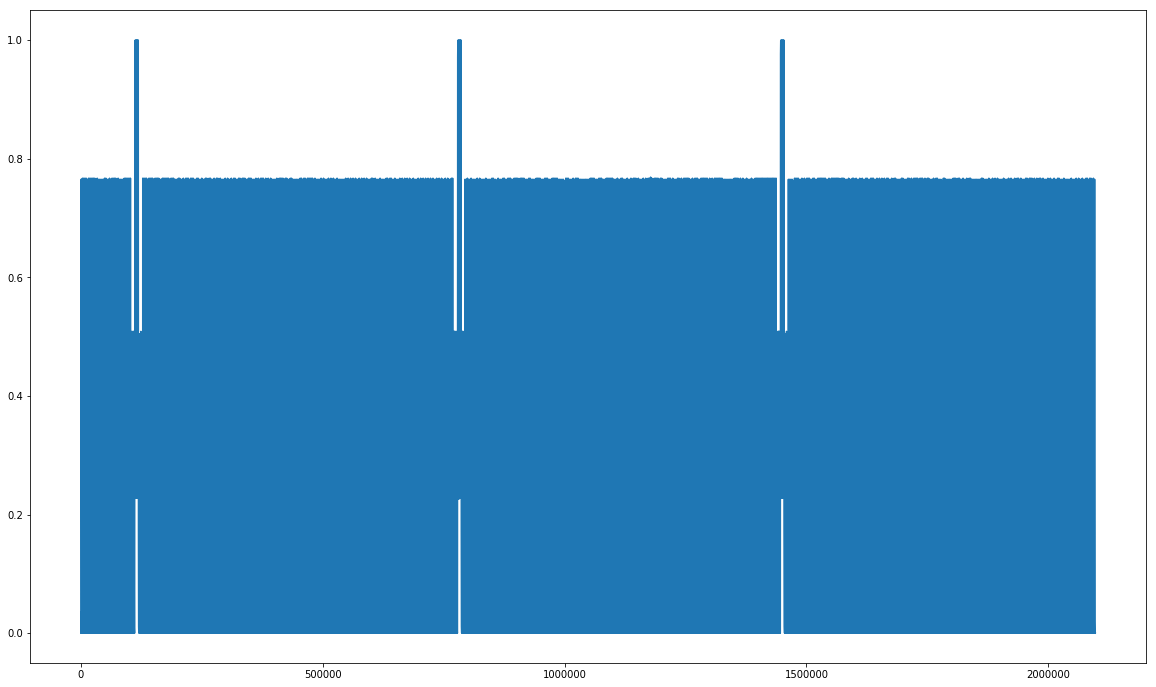

In [112]:
# This shows some nice patterns.  The glitches near the odd #'d syncs
plt.plot(output_syncf)

In [113]:
# state 1: find vsync and first full hsync.  determine which line it is as well...

loc = 400000
imglen = (int)((filterset['freq_hz'] / 59.976) * 1.25)

if (loc + imglen) > len(output_syncf):
    print("get more data")

# find the next sync point.  should be > .9
syncloc = np.argmax(output_syncf[loc:loc+imglen]) + loc

if np.max(output_syncf[loc:loc+imglen]) < .9:
    print("oops.  can't find a good sync")

syncloc

786033

In [114]:
def findburstfromsync(syncf, center):
    ilinepx = int(filterset['line_px'])

    if syncf[center] < .2:
        print('invalid location')
    try:
        scanarea = (ilinepx * 6)
        threshold = .15

        startsync = center - scanarea + np.where(syncf[center - scanarea:center] < threshold)[0][-1]
        # note: endsync usually includes the first equalization pulse
        endsync = center + np.where(syncf[center:center + scanarea] < threshold)[0][0]
    except:
        print('oh oh, sync ends not found')

    try:
        lastlinepresync = (startsync - (ilinepx * 4)) + np.where(syncf[startsync - (ilinepx * 4): startsync] > .55)[0][-1]
        # compute equalization length with .08 compensation factor
        presync_eqlen = ((startsync - lastlinepresync) / ilinepx) + .08
    except:
        print("error: couldn't find prev line")
        lastlinepresync = None
        presync_eqlen = None

    try:
        nextline = endsync + np.where(syncf[endsync: endsync + (ilinepx * 4)] > .55)[0][0]
        # the offset is larger here since the first equalization pulse is close enough to the end of vsync
        postsync_eqlen = ((nextline - endsync) / ilinepx) + .56
    except:
        print("error: couldn't find next line")
        nextline = None
        postsync_eqlen = None

    return (lastlinepresync, nextline, presync_eqlen, postsync_eqlen)

prevline, nextline, pregap, postgap = findburstfromsync(output_syncf, syncloc)

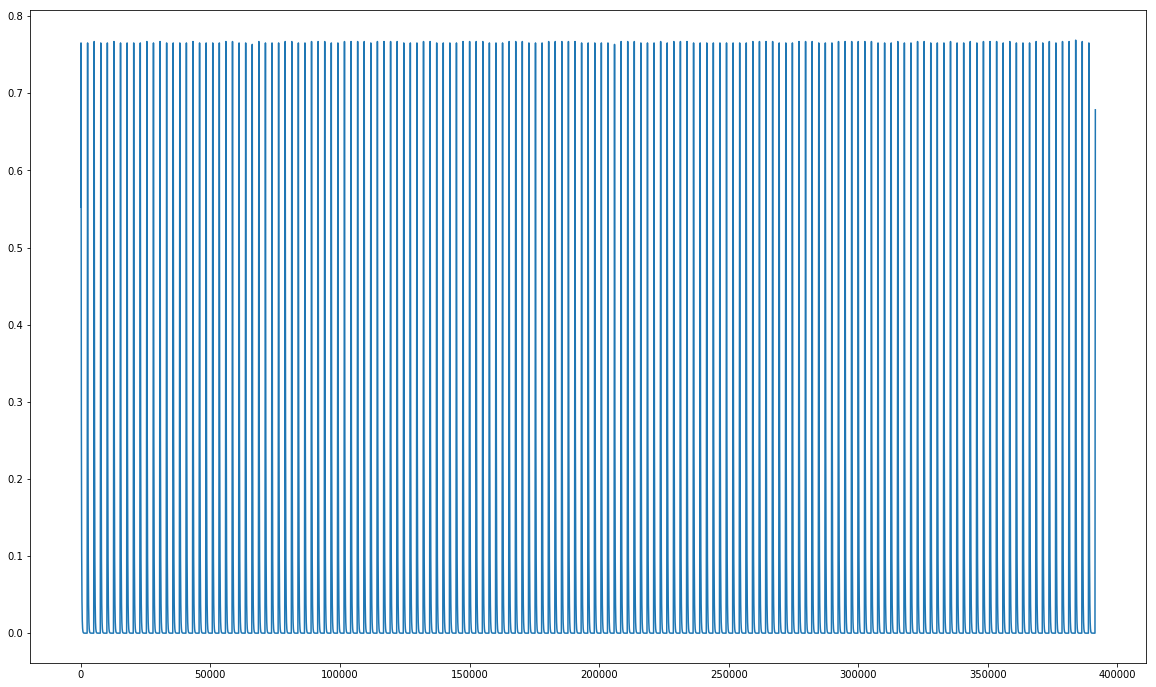

In [115]:
plt.plot(output_syncf[nextline:syncloc+399430])

In [116]:
reduced = (output - minn) / hz_ire_scale
output_u16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

In [117]:
# state 2: find the (rough) locations of each following line

ilinepx = int(filterset['line_px'])
lines = np.zeros((255 * ilinepx), dtype=np.uint16)

curloc = nextline

lineinfo = [curloc]
for i in range(0, 253):
    prevloc = curloc
    
    curloc += int(filterset['line_px'] * .9)
    offset = np.argmax(output_syncf[curloc:curloc + int(filterset['line_px'] * .2)])
    curloc += offset 
    
    # if the sync detection burst doesn't look good, reuse the last one
    is_validlinegap = inrange((curloc - prevloc), filterset['line_px'] * .997, filterset['line_px'] * 1.003)
    validaftersync = (np.max(output[curloc:curloc + 20]) < 8500000) and (np.min(output[curloc:curloc + 20]) >= 7600000)
    if (i >= 3) and (((output_syncf[curloc] < .7) and not is_validlinegap) or not validaftersync):
        print(i, curloc)
        curloc = prevloc + (lineinfo[-1] - lineinfo[-2])
        
    print(curloc, output[curloc], output[curloc+8])

    lineinfo.append(curloc)
    
    lines[i * ilinepx:(i * ilinepx)+(curloc - prevloc)] = output_u16[prevloc:curloc]
    
#    if (i == 119):
#        break

796574 7792391.74957 8100194.93596
799116 7775101.77987 8086325.73134
801657 7753077.4037 8084745.29755
804199 7763622.37738 8080283.98024
806741 7783314.16155 8084526.9249
809282 7737584.97645 8078442.89427
811824 7732508.90473 8055386.08263
814366 7741356.06583 8074573.96416
816908 7771200.18367 8086777.14637
819450 7785363.29551 8072134.04246
821991 7744823.57669 8067720.67218
824533 7762910.9228 8089972.77806
827074 7738774.12375 8069197.41966
829616 7754513.66629 8087333.95618
832158 7767502.09295 8071189.56327
834699 7745280.99483 8094377.08931
837242 7790059.68497 8072826.7551
839783 7751277.36045 8075639.85295
842325 7775311.44789 8085334.5679
844866 7740399.93548 8082990.57453
847408 7733399.88837 8081823.43878
849950 7789712.64525 8099220.61217
852492 7755567.21212 8074337.07996
855033 7734197.07818 8064883.14479
857575 7750975.10499 8094380.22363
860116 7739487.03295 8065491.98231
862659 7776322.74128 8069060.23943
865200 7753164.15739 8099159.86742
867742 7777554.45979 8088

In [118]:
m20ire = 8100000-hz_ire_scale*20

In [119]:
# crude zero-crossing calculator.

def calczc(data, start_offset, target, count=10):
    if data[start_offset] < target:
        locs = np.where(data[start_offset:start_offset+count] >= target)[0]
        offset = 0
    else:
        locs = np.where(data[start_offset:start_offset+count] <= target)[0]
        offset = -1
    
    if len(locs) == 0:
        return None
        
    x = start_offset + locs[0]
    
    a = data[x - 1] - target
    b = data[x] - target
    
    y = -a / (-a + b)

    #print(x, y, locs, data[start_offset:start_offset+locs[0] + 1])

    return x-1+y


In [120]:
video_05 = filtfft(sps.butter(3, 0.5/22, 'low'))
output_lp = np.fft.ifft(np.fft.fft(output) * video_05).real[29:] 

In [121]:
lineinfo2 = []

for l in lineinfo:
    zc = calczc(output_lp, l - 5, m20ire, 20)
    
    if zc is None:
        lineinfo2.append(l)
        continue
        
    lineinfo2.append(zc)
    print(l, output[l], output[l + 1], output[l + 2])
    


796574 7792391.74957 7843397.21349 7886903.90366
799116 7775101.77987 7831612.3069 7896497.60308
801657 7753077.4037 7809779.92602 7872536.47205
804199 7763622.37738 7824603.86033 7888054.62373
806741 7783314.16155 7839434.65645 7897805.4647
809282 7737584.97645 7798536.48345 7862149.86976
811824 7732508.90473 7800606.72299 7876171.44169
814366 7741356.06583 7816276.83323 7894204.07009
816908 7771200.18367 7833831.80121 7900416.57947
819450 7785363.29551 7855011.09351 7928320.96648
821991 7744823.57669 7818542.32274 7895493.23116
824533 7762910.9228 7814457.76582 7877331.4433
827074 7738774.12375 7805175.03441 7872955.83859
829616 7754513.66629 7818711.75282 7884627.88717
832158 7767502.09295 7840504.81285 7909341.12081
834699 7745280.99483 7810848.66191 7868993.14444
837242 7790059.68497 7865596.09198 7939183.33077
839783 7751277.36045 7822153.26364 7895067.73794
842325 7775311.44789 7830717.91098 7891016.77304
844866 7740399.93548 7796879.98872 7858179.53768
847408 7733399.88837 7801

In [122]:
lineinfo2e = []

c = 0
for l in lineinfo:
    zc = calczc(output_lp, int(l - 10 + (filterset['line_px'] * 55 / 63.5)), m20ire, 200)
    
    if zc is None:
        lineinfo2e.append(l)
        continue
        
    lineinfo2e.append(zc)
    print(l, lineinfo2[c], lineinfo2e[c], output[l], output[l + 1], output[l + 2])
    c += 1
    


796574 793950 793950 7792391.74957 7843397.21349 7886903.90366
799116 796577.239364 798929.743549 7775101.77987 7831612.3069 7896497.60308
801657 799119.084863 801471.833993 7753077.4037 7809779.92602 7872536.47205
804199 801660.24675 804013.856177 7763622.37738 7824603.86033 7888054.62373
806741 804202.159968 806555.507346 7783314.16155 7839434.65645 7897805.4647
809282 806743.76698 809097.293113 7737584.97645 7798536.48345 7862149.86976
811824 809285.781682 811638.751609 7732508.90473 7800606.72299 7876171.44169
814366 811827.616153 814180.417747 7741356.06583 7816276.83323 7894204.07009
816908 814369.430149 816722.248669 7771200.18367 7833831.80121 7900416.57947
819450 816911.069456 819263.656134 7785363.29551 7855011.09351 7928320.96648
821991 819452.686026 821801.068216 7744823.57669 7818542.32274 7895493.23116
824533 821994.300695 824347.88466 7762910.9228 7814457.76582 7877331.4433
827074 824535.892399 826889.398768 7738774.12375 7805175.03441 7872955.83859
829616 827077.473274 

In [123]:
# experiment:  filter color burst data for easier alignment

In [124]:
video_cburst = filtfft(sps.butter(2, [(300/88.0)/22, (330/88.0)/22], 'bandpass'))


In [125]:
output_cburst = np.fft.ifft(np.fft.fft(output - 8100000) * video_cburst).real[98:] + 8100000

In [126]:
calczc(output_lp, int(lineinfo2[250])-80, m20ire, 200), calczc(output, int(lineinfo2[250])-80, m20ire, 200)

(1429626.357300706, 1429624.4196304092)

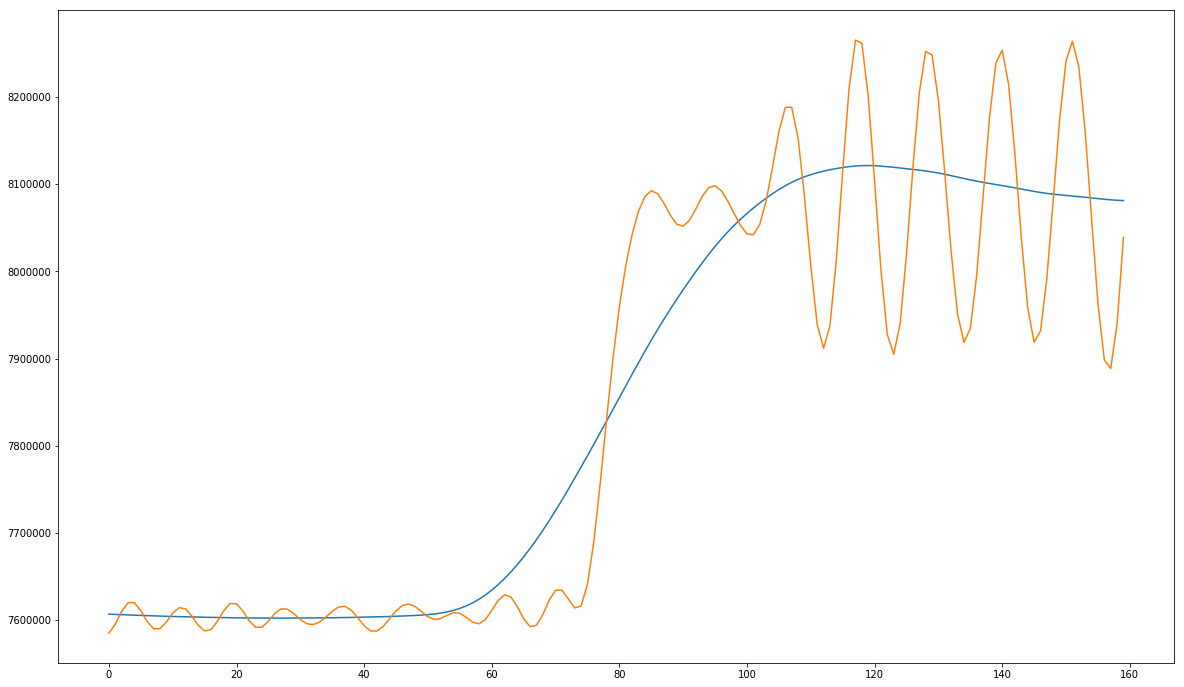

In [127]:
plt.plot(output_lp[int(lineinfo2[250]-80):int(lineinfo2[250])+80])
plt.plot(output[int(lineinfo2[250])-80:int(lineinfo2[250])+80])
#plt.plot(output[int(lineinfo2[50]):int(lineinfo2[51])])

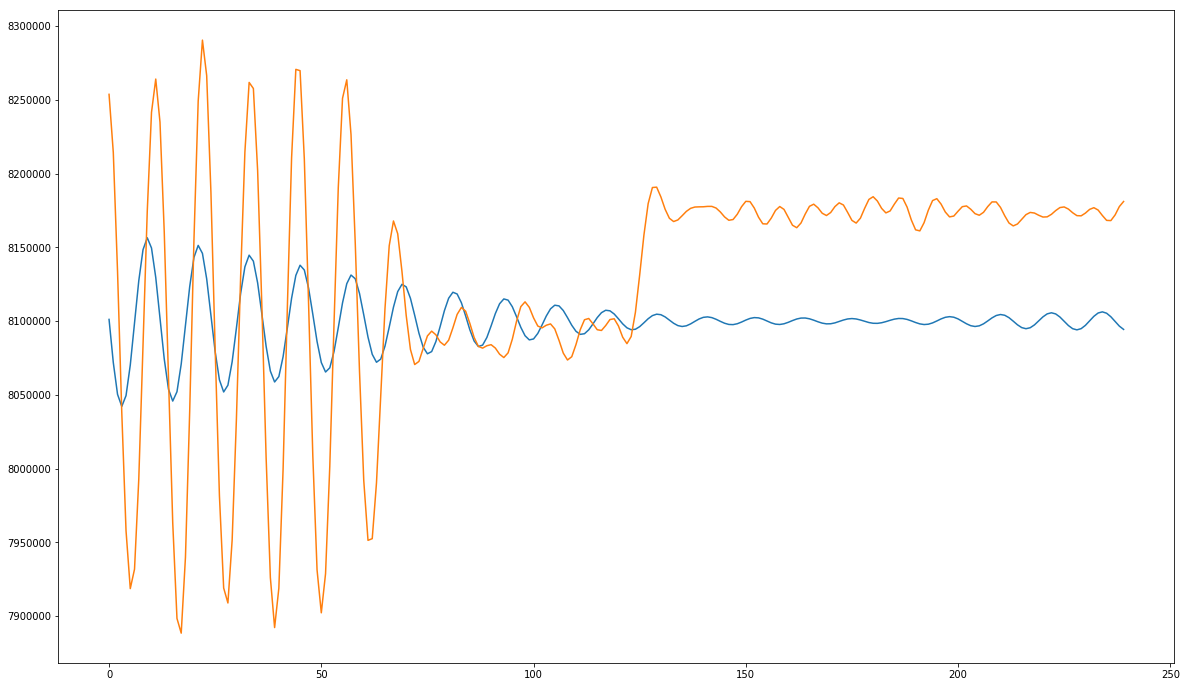

In [128]:
plt.plot(output_cburst[int(lineinfo2[250]+60):int(lineinfo2[250])+300])
plt.plot(output[int(lineinfo2[250])+60:int(lineinfo2[250])+300])
#plt.plot(output[int(lineinfo2[50]):int(lineinfo2[51])])

In [129]:
lineinfo2 = []

for l in lineinfo:
    zc = calczc(output_lp, l - 5, m20ire, 20)
    
    if zc is None:
        lineinfo2.append(l)
        continue
        
    lineinfo2.append(zc)
    print(l, output[l], output[l + 1], output[l + 2])
    


796574 7792391.74957 7843397.21349 7886903.90366
799116 7775101.77987 7831612.3069 7896497.60308
801657 7753077.4037 7809779.92602 7872536.47205
804199 7763622.37738 7824603.86033 7888054.62373
806741 7783314.16155 7839434.65645 7897805.4647
809282 7737584.97645 7798536.48345 7862149.86976
811824 7732508.90473 7800606.72299 7876171.44169
814366 7741356.06583 7816276.83323 7894204.07009
816908 7771200.18367 7833831.80121 7900416.57947
819450 7785363.29551 7855011.09351 7928320.96648
821991 7744823.57669 7818542.32274 7895493.23116
824533 7762910.9228 7814457.76582 7877331.4433
827074 7738774.12375 7805175.03441 7872955.83859
829616 7754513.66629 7818711.75282 7884627.88717
832158 7767502.09295 7840504.81285 7909341.12081
834699 7745280.99483 7810848.66191 7868993.14444
837242 7790059.68497 7865596.09198 7939183.33077
839783 7751277.36045 7822153.26364 7895067.73794
842325 7775311.44789 7830717.91098 7891016.77304
844866 7740399.93548 7796879.98872 7858179.53768
847408 7733399.88837 7801

In [130]:
# now to get fine sync!

In [131]:
from scipy import interpolate

# This uses numpy's interpolator, which works well enough
def scale(buf, begin, end, tgtlen):
#        print("scaling ", begin, end, tgtlen)
        ibegin = int(begin)
        iend = int(end)
        linelen = end - begin

        dist = iend - ibegin + 0
        
        sfactor = dist / tgtlen
        
        arr, step = np.linspace(0, dist, num=dist + 1, retstep=True)
        spl = interpolate.splrep(arr, buf[ibegin:ibegin + dist + 1])
        arrout = np.linspace(begin - ibegin, linelen + (begin - ibegin), tgtlen + 1)

        return interpolate.splev(arrout, spl)[:-1]
    

x = np.arange(0, 400)
scale(x, 50.5, 60.5, 10)

array([ 50.5,  51.5,  52.5,  53.5,  54.5,  55.5,  56.5,  57.5,  58.5,  59.5])

In [132]:
def downscale(data, lineinfo):
    dsout = np.zeros((len(lineinfo) * ilinepx), dtype=np.double)    

    sfactor = []

    for l in range(0, len(lineinfo) - 1):
#        scaled = scale(data, lineinfo[l] + 0, lineinfo[l + 1], 910)
#        sfactor.append((lineinfo[l + 1] - lineinfo[l]) / 910)
        scaled = scale(data, lineinfo[l][0], lineinfo[l][1], 910)
        sfactor.append((lineinfo[l][1] - lineinfo[l][0]) / 910)

        dsout[l * 910:(l + 1)*910] = scaled
        
    return dsout, sfactor

#lines, sfactor = downscale(output_cburst, lineinfo3)
    
#reduced = (lines - minn) / hz_ire_scale
#lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)


In [133]:
#drawdata(lines16, 910, len(lineinfo2)-1, hscale=2, vscale=4)

In [134]:
def phasecorrect(sdata, lineinfo, mult = 0.25):
    loutput = []
    errors = []

    #loutput.append(lineinfo[0])
    for l in range(0, len(lineinfo) - 1):
        subset = sdata[l * 910: (l + 1) * 910][5:60]

        if (np.min(subset) < 7600000) or (np.max(subset) > 8500000):
            loutput.append(lineinfo[l])
            errors.append(0)
            continue
        
        peaks = np.where(np.abs(subset - 8100000) > 80000)[0]
        toffset = 0

        for loc in peaks:
            zp = calczc(subset, loc, 8100000)

            if zp is not None:
                offset = (zp - loc - 1)
                toffset += offset
            else:
                offset = 0

    #        print(zp, offset)

        errors.append(toffset)
        #print(l, toffset / len(peaks) * sfactor[l])

        if len(peaks):
            loutput.append(lineinfo[l] - ((toffset * mult) / len(peaks) * sfactor[l]))
        else:
            loutput.append(lineinfo[l])

    loutput.append(lineinfo[-1])
    
    return loutput, errors

In [135]:
def calcerr(line):
    subset = line[5:60]
    
    black = np.mean(subset)
    
    peaks = np.where(np.abs(subset - black) > 100000)[0]
    toffset = 0
    noffsets = 0

    for loc in peaks:
        zp = calczc(subset, loc, black)

        #print(loc, subset[loc], zp)
        
        if zp is not None:
            offset = (zp - loc - 1)
            toffset += offset
            noffsets += 1
        else:
            offset = 0
            
    try:
        return toffset / noffsets
    except:
        return 0


In [136]:
910 * 1.2

1092.0

In [149]:
lineinfo_tmp = lineinfo2.copy()
#lineinfo3 = [(lineinfo2[0], lineinfo[1])]
lineinfo3 = [(lineinfo2[0], lineinfo[1])]
finalsnr = []

# because of odd issues, it makes sense to do one line and the next burst together, and so on...
for l in range(1, len(lineinfo2) - 1):
    for i in range(0, 5):
        # compute 1.2x
        linelen = lineinfo_tmp[l + 1] - lineinfo_tmp[l]
        line12end = lineinfo_tmp[l] + (linelen * 1.2)

        scaled = scale(output, lineinfo_tmp[l], line12end, 1092) # 1092 is 1.2x 910
#        sfactor.append((lineinfo[l + 1] - lineinfo[l]) / 910)

        offset1 = calcerr(scaled[0:60])
        offset2 = calcerr(scaled[910:970])
        print(l, i, offset1, offset2, calcsnr((scaled[10:50] + scaled[920:960]) / 2))

#        lineinfo_tmp[l] -= (offset1 * (linelen / 910) * (.5 / (i + 1)))
        #lineinfo3[l + 1] += (offset1 * (linelen / 910) * .25)
        if (i == 0):
            lineinfo_tmp[l + 1] -= ((offset2 - offset1) * (linelen / 910) * (0.83 / (i + 1)))
        else:
            lineinfo_tmp[l] += (offset1 * (linelen / 910) * (.4 / (i + 1)))
            lineinfo_tmp[l + 1] += ((offset2) * (linelen / 910) * (.4 / (i + 1)))
            
    lineinfo3.append((lineinfo_tmp[l], lineinfo_tmp[l + 1]))
    linelen = lineinfo3[l][1] - lineinfo3[l][0]
    line12end = lineinfo3[l][0] + (linelen * 1.2)

    scaled = scale(output, lineinfo3[l][0], line12end, 1092) # 1092 is 1.2x 910
    offset1 = calcerr(scaled[0:60])
    offset2 = calcerr(scaled[910:970])
    finalsnr.append(calcsnr((scaled[10:50] + scaled[920:960]) / 2))
    print(l, 'f', offset1, offset2, calcsnr((scaled[10:50] + scaled[920:960]) / 2))
    
lineinfo3.append((lineinfo2[-1], lineinfo2[-1] + linelen))
#lineinfo3.append(lineinfo2[-1])

1 0 0.361830576251 0.300035059984 42.4692157165
1 1 0.360472568806 0.249622687217 39.9491776534
1 2 0.29657014469 0.19843372105 41.0415051562
1 3 0.255318058049 0.169301264902 41.6953624591
1 4 0.229836507061 0.149787884831 42.1199229555
1 f 0.210778470825 0.135258851834 42.4288359549
2 0 0.149464243342 0.0233129722081 31.0458189582
2 1 0.145807358708 0.176746633876 33.4017791023
2 2 0.108755792232 0.228684442239 33.5606738266
2 3 0.0892631458479 0.299165122627 33.9862600036
2 4 0.0766084623637 0.329133788761 34.5743650538
2 f 0.0675901272921 0.311928803584 35.1736499311
3 0 0.311089381513 0.0158569942314 37.5091908648
3 1 0.304389656242 0.233887486813 42.231420752
3 2 0.246176530059 0.183996555702 42.9809409386
3 3 0.21242796469 0.155936979462 43.4026617368
3 4 0.189500093194 0.13731034934 43.675887999
3 f 0.172545209451 0.123783628792 43.8680386496
4 0 0.139619965591 -0.0161956352678 31.2330276144
4 1 0.135005002174 0.340849812548 34.571354753
4 2 0.0989831400372 0.335104780747 35.96

38 2 0.123230532937 0.321127555771 36.3283700069
38 3 0.101475907891 0.280389657623 37.2939711468
38 4 0.0878091759376 0.252250261468 37.9892101969
38 f 0.0781855199083 0.23114769524 38.5193353324
39 0 0.232390626831 0.281486870693 37.2430246729
39 1 0.233682681669 0.146790920208 35.7475608066
39 2 0.183461217786 0.276862929957 35.1755237309
39 3 0.154407740558 0.358767266735 35.5896023111
39 4 0.134724814111 0.326936878393 36.304631878
39 f 0.120501823547 0.302885750324 36.876163659
40 0 0.303147568396 0.0828032383315 36.7673534425
40 1 0.29820256032 0.29128149984 42.8972152579
40 2 0.240633444972 0.253429426875 42.8824535502
40 3 0.207172724511 0.218312928899 42.8685205647
40 4 0.184459943115 0.194395114247 42.8569708616
40 f 0.167529158997 0.176685748055 42.8475927891
41 0 0.187195392733 0.0384004208097 32.7121780451
41 1 0.182840195063 0.309507202075 36.3637527929
41 2 0.138416353866 0.306710565905 37.2946216199
41 3 0.114253739963 0.267453118978 38.1734959481
41 4 0.0987415034491 

78 2 0.141969655152 0.256871136961 34.9395897878
78 3 0.117788555493 0.226957408982 35.4455059529
78 4 0.102173021021 0.251926930289 35.8226127546
78 f 0.09090967364 0.285210319401 36.2530102659
79 0 0.28352058862 0.112139754508 36.4942257407
79 1 0.27965866211 0.316891431 40.8668386339
79 2 0.241521518436 0.256485929734 40.9626824715
79 3 0.207633498213 0.221387683175 40.9846233261
79 4 0.184647764762 0.197467079194 40.998603957
79 f 0.167680526106 0.179738282904 41.0083811919
80 0 0.187234979196 0.178984879784 34.6551540383
80 1 0.187009433975 0.209700269011 34.8511476086
80 2 0.143467809795 0.303013765444 34.9801423657
80 3 0.119454510569 0.316700256537 35.6126209868
80 4 0.103897977917 0.287012190369 36.2233614348
80 f 0.0928634961531 0.26461894807 36.6898019576
81 0 0.265086208973 0.179774805293 37.8368154579
81 1 0.263009940567 0.34765902741 41.3387136626
81 2 0.20872973929 0.284245275915 42.2902896341
81 3 0.177707417012 0.246964382313 42.8537937646
81 4 0.156827003572 0.2213515

119 0 -0.220643655454 0.2327066797 29.1979746841
119 1 -0.208068790693 -0.297008936934 39.7709806564
119 2 -0.161473151347 -0.238068022318 40.5367584758
119 3 -0.136078591865 -0.205079291709 40.9632940946
119 4 -0.119471319253 -0.182868152815 41.2408236366
119 f -0.107340696706 -0.166742287139 41.4372154417
120 0 -0.182169277623 0.258407405521 28.5442376597
120 1 -0.169167394769 -0.224073563247 37.261911951
120 2 -0.130860519301 -0.284233612945 37.666338279
120 3 -0.119734647613 -0.24780831984 38.4347495562
120 4 -0.105045456991 -0.22256991805 38.9208305774
120 f -0.0945289416934 -0.202763487364 39.2759318158
121 0 -0.217594096134 0.322716086209 29.3196809948
121 1 -0.201536245878 -0.23890370563 41.98259369
121 2 -0.155562160765 -0.189030660281 42.1259123883
121 3 -0.130777127782 -0.172465332467 42.1938619322
121 4 -0.114625868789 -0.151646259108 42.2446481937
121 f -0.103055849823 -0.136763535808 42.2731238579
122 0 -0.155480915694 0.0681280597209 29.2146344104
122 1 -0.148392322998 -

159 3 -0.100878985868 -0.25581081542 39.0074800168
159 4 -0.0874499464202 -0.230116511303 39.7632114068
159 f -0.0779911196478 -0.210903687371 40.3428186678
160 0 -0.222786426078 0.292093934886 29.3942886136
160 1 -0.209264911031 -0.245066441106 43.1402309981
160 2 -0.163483398567 -0.193505284103 43.393176009
160 3 -0.137988800355 -0.164040968917 43.5189344829
160 4 -0.121176379619 -0.144684811498 43.5941290159
160 f -0.108565016168 -0.130692210597 43.6449953485
161 0 -0.151313252204 0.276186037869 27.3951864255
161 1 -0.138052791604 -0.184286523833 34.6234510445
161 2 -0.103582068592 -0.235321289322 34.9252967831
161 3 -0.0853242051643 -0.316672505015 35.5266398948
161 4 -0.0732337785689 -0.287199657951 36.3801857356
161 f -0.0647511279972 -0.264997642766 37.061783842
162 0 -0.274082300377 0.265364283325 29.7272580397
162 1 -0.260844244552 -0.256788396572 43.8915390116
162 2 -0.20745938437 -0.205593412342 43.9011739557
162 3 -0.176641606112 -0.174901079492 43.9040065692
162 4 -0.15631

203 4 -0.0504457072225 -0.25011138028 36.4066615317
203 f -0.0441482587111 -0.241140813752 36.9607112146
204 0 -0.251061492942 0.255578447612 29.1858741859
204 1 -0.238037784589 -0.332988506954 41.2308864403
204 2 -0.188296274105 -0.272237719243 42.0616865584
204 3 -0.160535859995 -0.236705048558 42.511194797
204 4 -0.142070996831 -0.212367320834 42.7888936146
204 f -0.128358166973 -0.194244091509 42.9750101337
205 0 -0.211004553397 0.341096283301 28.416327335
205 1 -0.196247371365 -0.266665209789 40.054895233
205 2 -0.152089277954 -0.213473455439 40.5625913804
205 3 -0.127721150111 -0.181646114795 40.8397112443
205 4 -0.11144276298 -0.160646314268 41.012605957
205 f -0.0998797797991 -0.145405835002 41.1330790539
206 0 -0.162998754523 0.348447393603 28.3703544856
206 1 -0.147044315319 -0.275598436486 39.1645982406
206 2 -0.110272630863 -0.218538077288 40.3162003331
206 3 -0.0912979001075 -0.186686884528 40.9680514708
206 4 -0.0793239842349 -0.165639135183 41.3904652119
206 f -0.0708916

244 4 -0.0812948363236 -0.201560158886 40.7858006566
244 f -0.0722546188725 -0.183941702068 41.3258600123
245 0 -0.198019594403 0.331695856957 28.1095652104
245 1 -0.18330531474 -0.292822707145 40.8240228378
245 2 -0.141247546842 -0.235855809015 42.2480830413
245 3 -0.11852705763 -0.202316484293 43.133511024
245 4 -0.10384246004 -0.180049296333 43.7424360459
245 f -0.0933530279008 -0.163797090214 44.1918600499
246 0 -0.182332238631 0.327080271734 27.8637864781
246 1 -0.167132639299 -0.314092809933 38.3444387483
246 2 -0.127495176683 -0.254872333277 39.7109063045
246 3 -0.106231679939 -0.219268549128 40.5453715821
246 4 -0.0925333589604 -0.195403508148 41.1094694828
246 f -0.0828267595252 -0.177944633662 41.5189225786
247 0 -0.196471390022 0.297581076661 27.4824318807
247 1 -0.181901482154 -0.210974034786 36.6224243212
247 2 -0.140261897467 -0.318608574542 36.8419346717
247 3 -0.116980117911 -0.279458790896 37.7842042658
247 4 -0.101903470291 -0.252424590325 38.4646469917
247 f -0.09113

In [150]:
np.mean(finalsnr), np.min(finalsnr), np.argmin(finalsnr)

(40.495972264292071, 31.362489344445585, 81)

In [151]:
for i in range(len(lineinfo3) - 1):
    print(i, lineinfo3[i + 1][0] - lineinfo3[i][1], lineinfo3[i])

0 3.6738853479 (793950, 796574)
1 0.163959369413 (796577.6738853479, 799119.52225567959)
2 0.363424839452 (799119.68621504901, 801660.88000328478)
3 0.150173207745 (801661.24342812423, 804203.11771497771)
4 0.269581801374 (804203.26788818545, 806744.57942152256)
5 0.221302207559 (806744.84900332394, 809286.50073033676)
6 0.394012292265 (809286.72203254432, 811827.73486894974)
7 0.20383128454 (811828.12888124201, 814369.93681023142)
8 0.33907214622 (814370.14064151596, 816911.36043495568)
9 0.173345581978 (816911.6995071019, 819453.47049925756)
10 0.393035419402 (819453.64384483953, 821994.6125787046)
11 0.211227755644 (821995.00561412401, 824536.72816292581)
12 0.318761070492 (824536.93939068145, 827078.21058273583)
13 0.202815111261 (827078.52934380632, 829620.17477128026)
14 0.25525911618 (829620.37758639152, 832161.80951468763)
15 0.212833352736 (832162.06477380381, 834703.66106277297)
16 0.283909933991 (834703.8738961257, 837245.13349385874)
17 0.194420380634 (837245.41740379273, 8

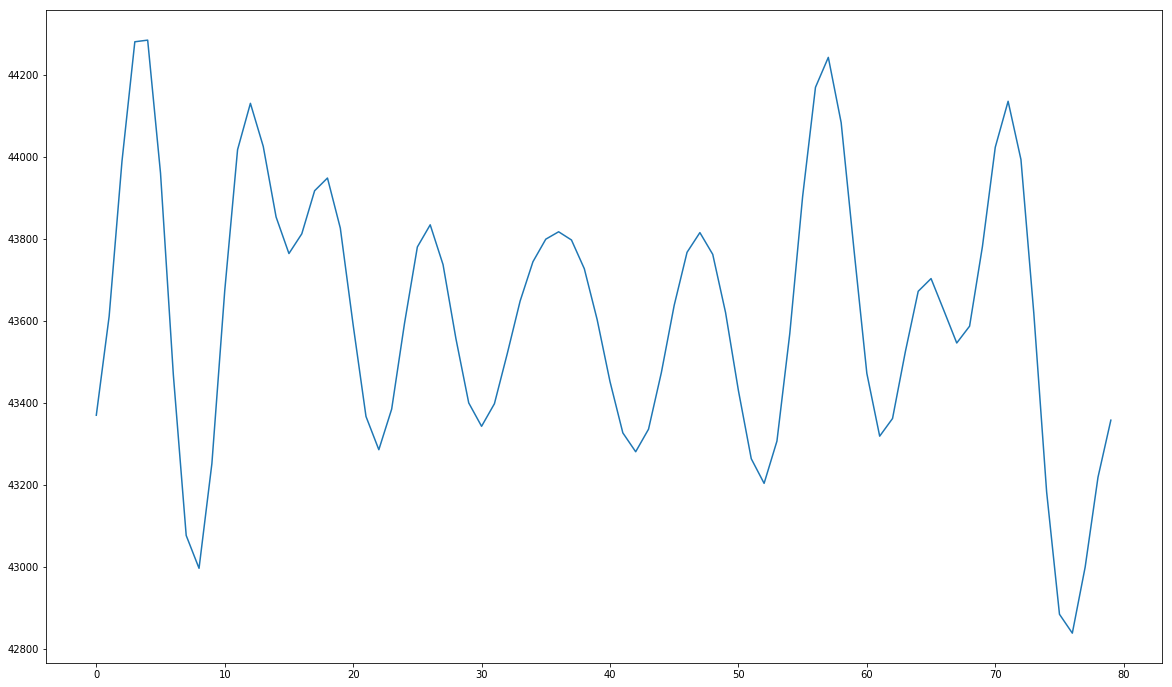

In [140]:
l1 = 153
#plt.plot(lines[(l1 * 910):(l1 * 910) + 80])
l2 = 154
#plt.plot(lines[(l2 * 910):(l2 * 910) + 80])
plt.plot(lines[(l1 * 910):(l1 * 910) + 80] + lines[(l2 * 910):(l2 * 910) + 80])

40.4959722643
(230230,)
uint8 (253, 910) (253, 910)


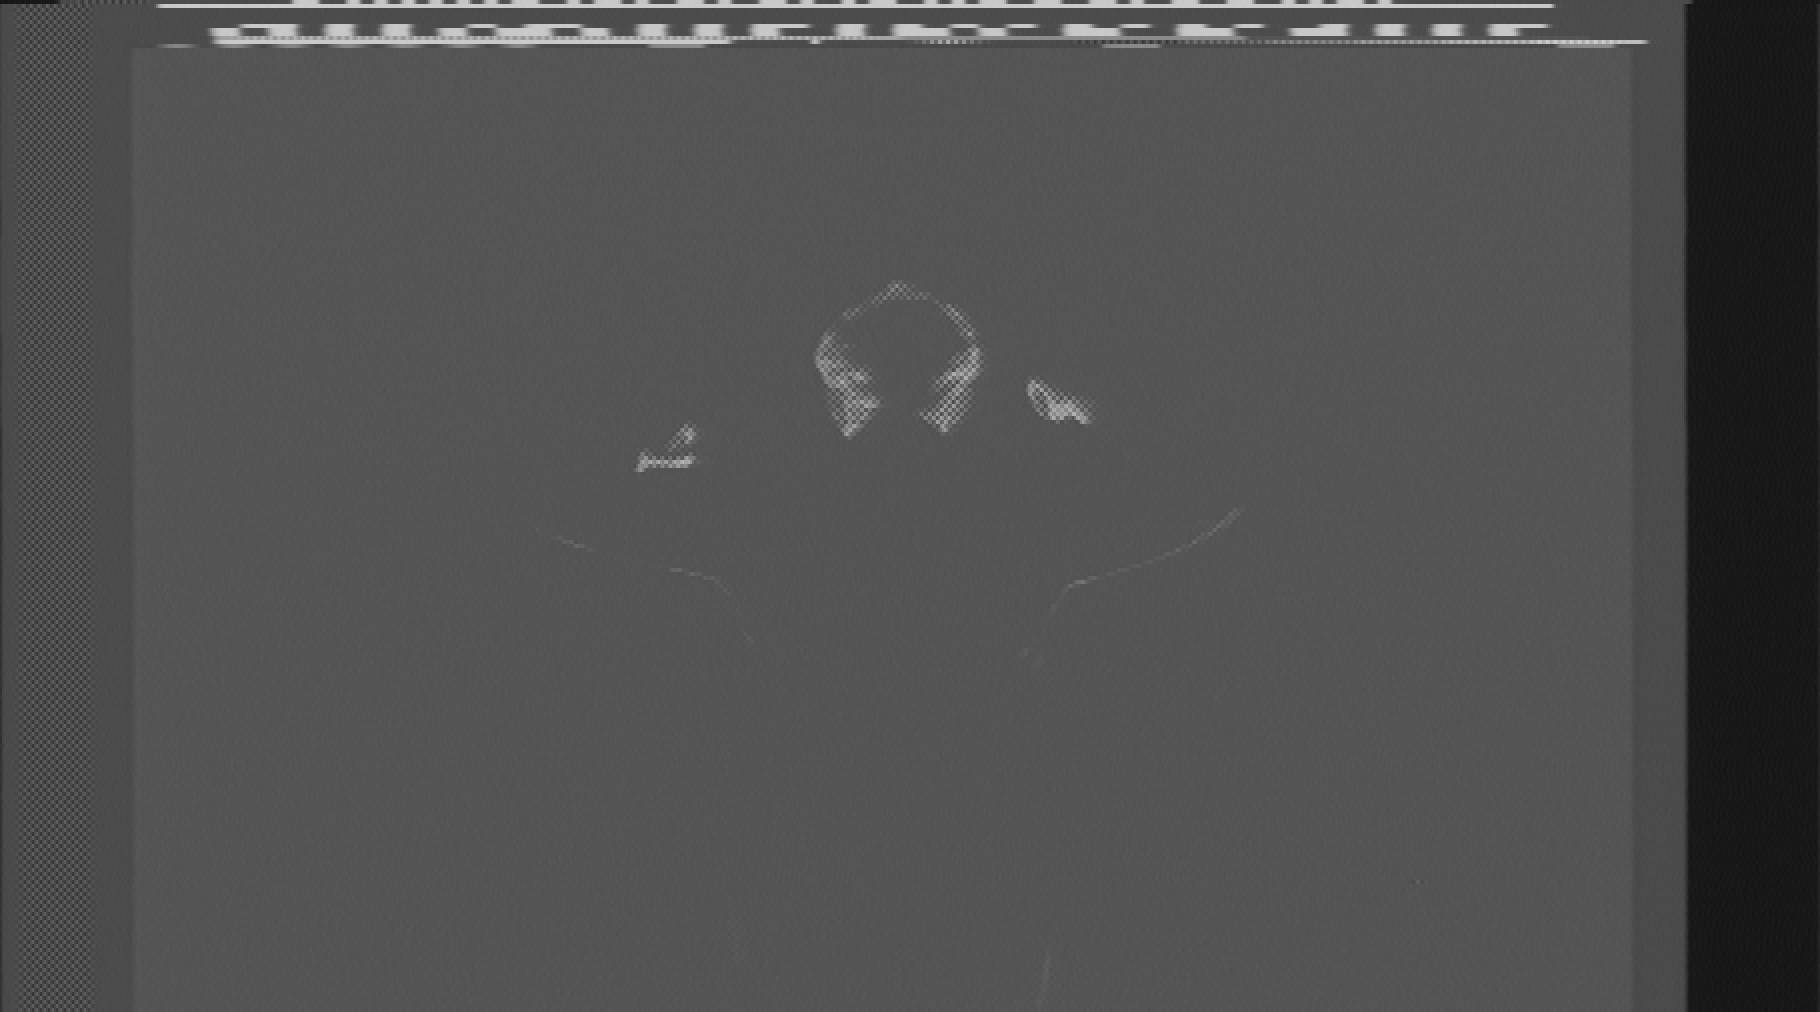

In [152]:
print(np.mean(finalsnr))
lines, sfactor = downscale(output, lineinfo3)

reduced = (lines - minn) / hz_ire_scale
lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

drawdata(lines16, 910, len(lineinfo2)-1, hscale=2, vscale=4)

7.4395057939439768

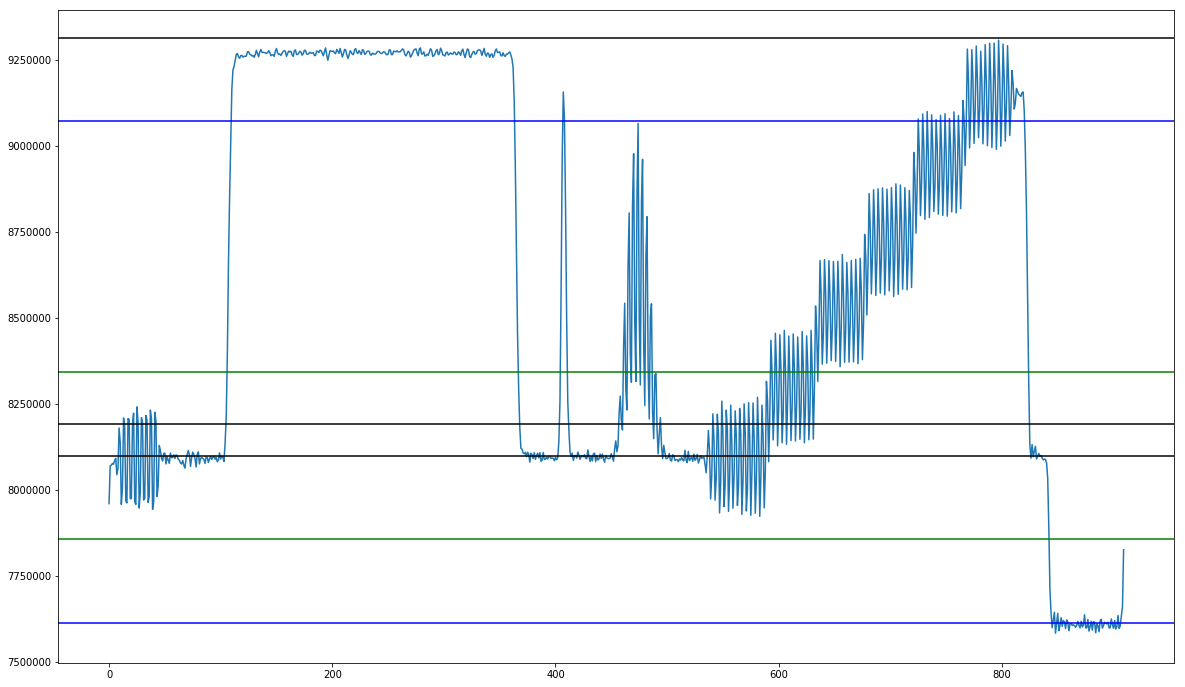

In [148]:
l = 10
x = lines[(910*l)+0:(910*l)+910]
lineplot(x, filterset)
calcsnr(x[180:700])

44.86094518088403

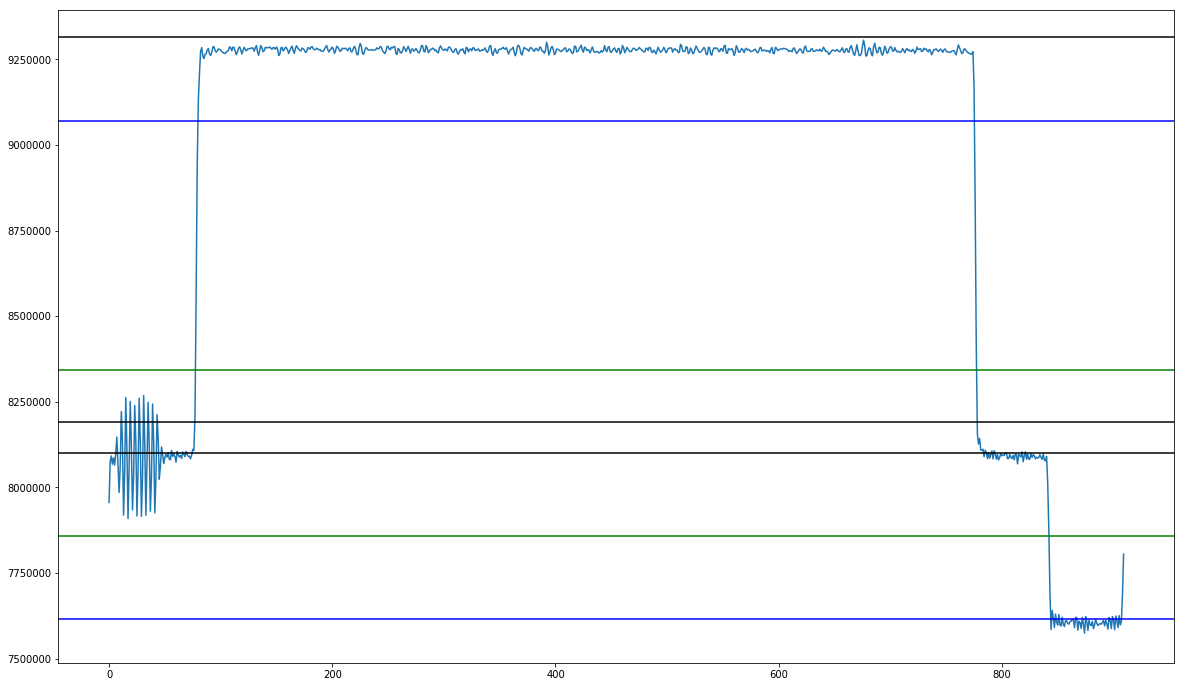

In [146]:
l = 1
x = lines[(910*l)+0:(910*l)+910]
lineplot(x, filterset)
calcsnr(x[180:700])

42.852129258019282

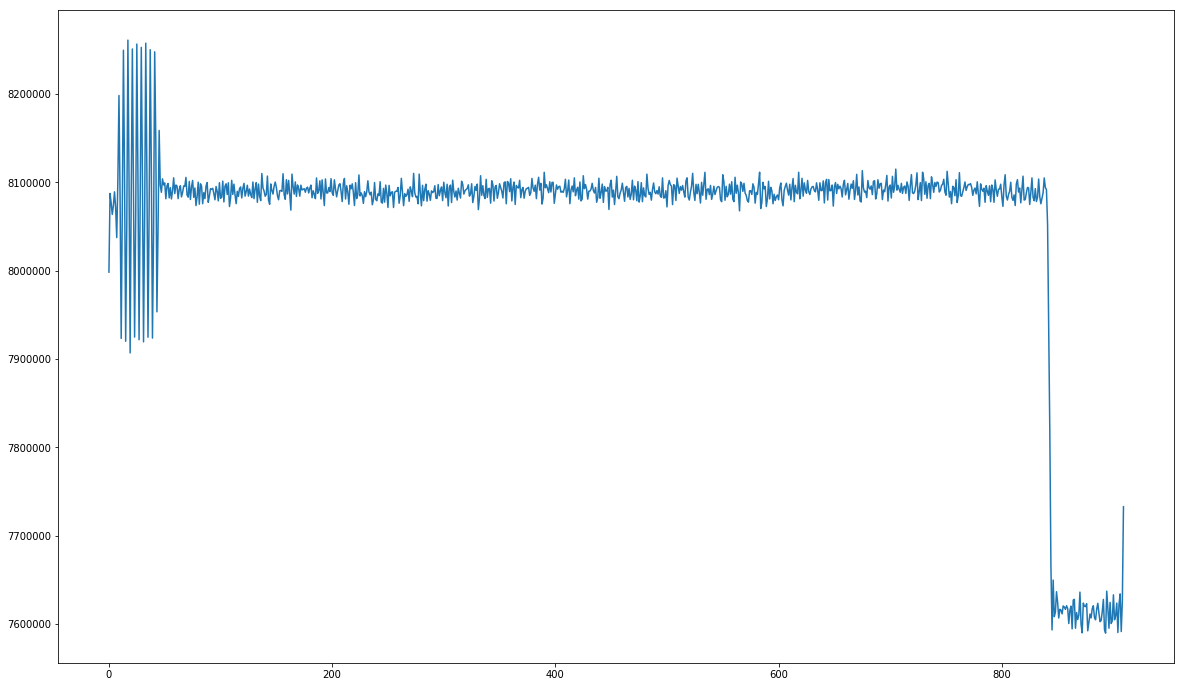

In [145]:
l = 2
x = lines[(910*l)+0:(910*l)+910]
plt.plot(x)
calcsnr(x[180:700])

In [695]:
snr = []
zcstart = []
zcend = []
zclen = []
for l in range(2, 250):
    preline = lines[(l * 910) - 20: (l * 910) + 20]
    _line = lines[(l * 910):(l + 2) * 910]
    
    x = lines[(910*l)+0:(910*l)+80]
    y = (x + lines[(910*l)+910:(910*l)+990]) / 2
    #plt.plot(y)

    zcstart.append(calczc(preline, 0, m20ire, 40) - 20)
    zcend.append(calczc(_line, 830, m20ire, 40))
    nextstart = calczc(_line, 900, m20ire, 40)
    zclen.append(nextstart - zcend[-1])
    snr.append(calcsnr(y[15:50]))
    print(l, calczc(preline, 0, m20ire, 40) - 20, calczc(_line, 830, m20ire, 40), calczc(_line, 900, m20ire, 40), calcsnr(y[15:50]))

2 -0.154741137918 845.368979898 909.861959977 37.4950262196
3 -0.138040022963 845.484546213 909.9074071 39.53515591
4 -0.0925929003539 845.450885029 909.909596074 38.2483850861
5 -0.0904039259235 845.431623837 909.909069945 38.7810154812
6 -0.090930054506 845.442284106 909.86090586 38.7791257511
7 -0.139094139965 845.425737295 909.832417702 39.7752201802
8 -0.167582298308 845.27221555 909.925389741 38.3505643762
9 -0.0746102585259 845.027630874 909.812592829 34.1564994399
10 -0.187407171451 845.224789305 909.883270826 38.0456201704
11 -0.116729174283 845.393663928 909.831584864 37.2948848883
12 -0.168415135823 845.195340354 909.928115571 36.7303025515
13 -0.0718844287775 845.338972519 909.837234703 36.2558223715
14 -0.162765296637 845.386983961 909.95733255 36.5790130216
15 -0.0426674502844 845.357508123 909.888763879 40.4586957605
16 -0.111236121343 845.278593138 909.928385346 37.6993434262
17 -0.0716146538122 845.114413832 909.880244413 38.2993437394
18 -0.119755586585 845.315334887 

In [696]:
np.mean(zclen), np.std(zclen)

(64.535136767752377, 0.11737262082938797)

In [697]:
np.std(zcstart), np.std(zcend), np.mean(snr)

(0.062264975967787954, 0.10891155743135103, 38.206862345726094)

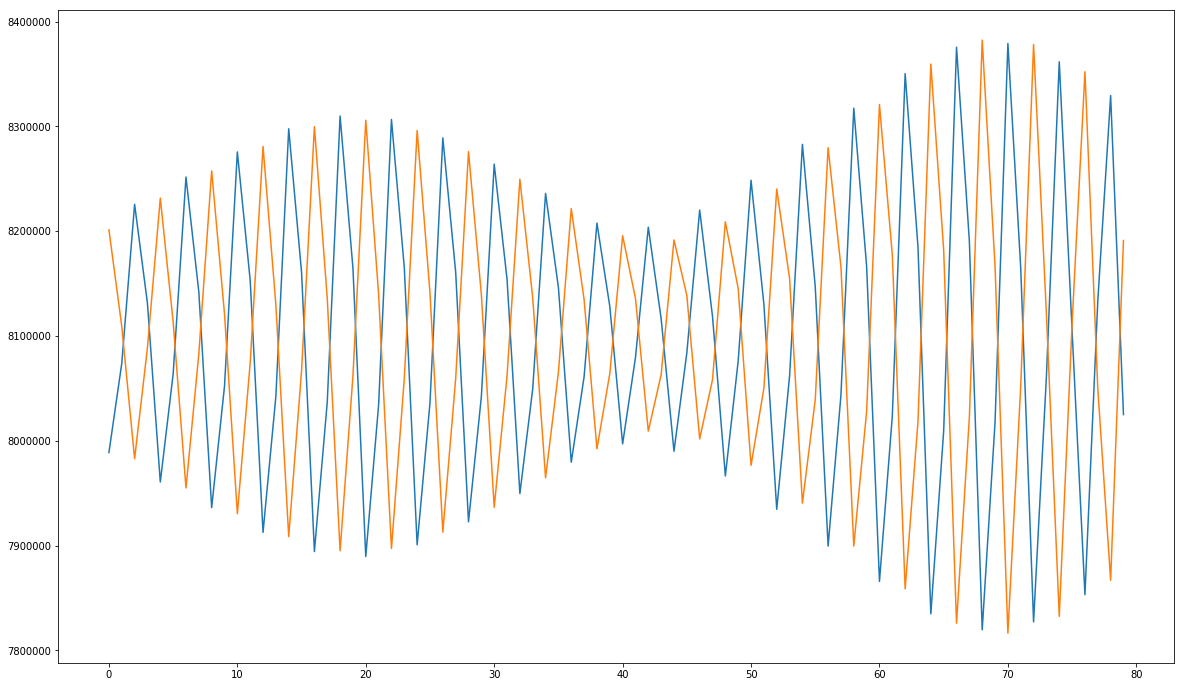

In [913]:
l = 17
x = lines[(910*l)+0:(910*l)+80]
plt.plot(x)
l = l + 1
x = lines[(910*l)+0:(910*l)+80]
plt.plot(x)


In [770]:
lineinfo_cur[100], lineinfo_cur[101]

(1160549.1033076106, 1163347.4488508701)

43.451705388955098

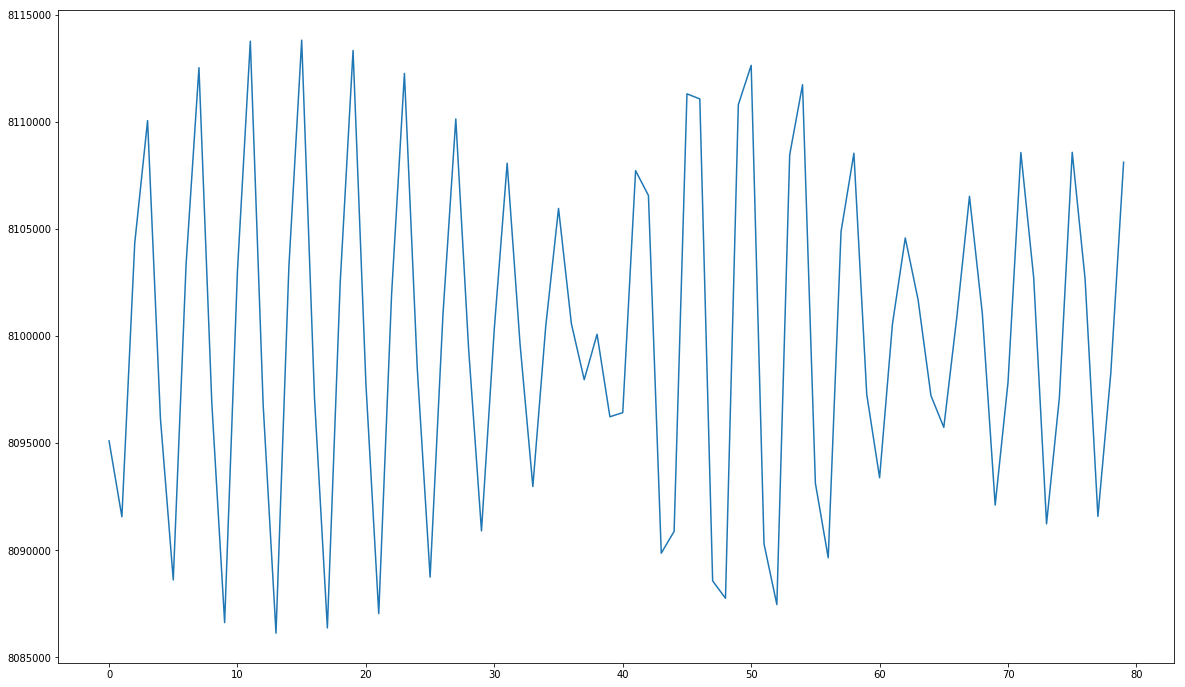

In [914]:
l = 17
x = lines[(910*l)+0:(910*l)+80]
#plt.plot(x)
l = l + 1
y = (x + lines[(910*l)+0:(910*l)+80]) / 2
plt.plot(y)
calcsnr(y[15:50])


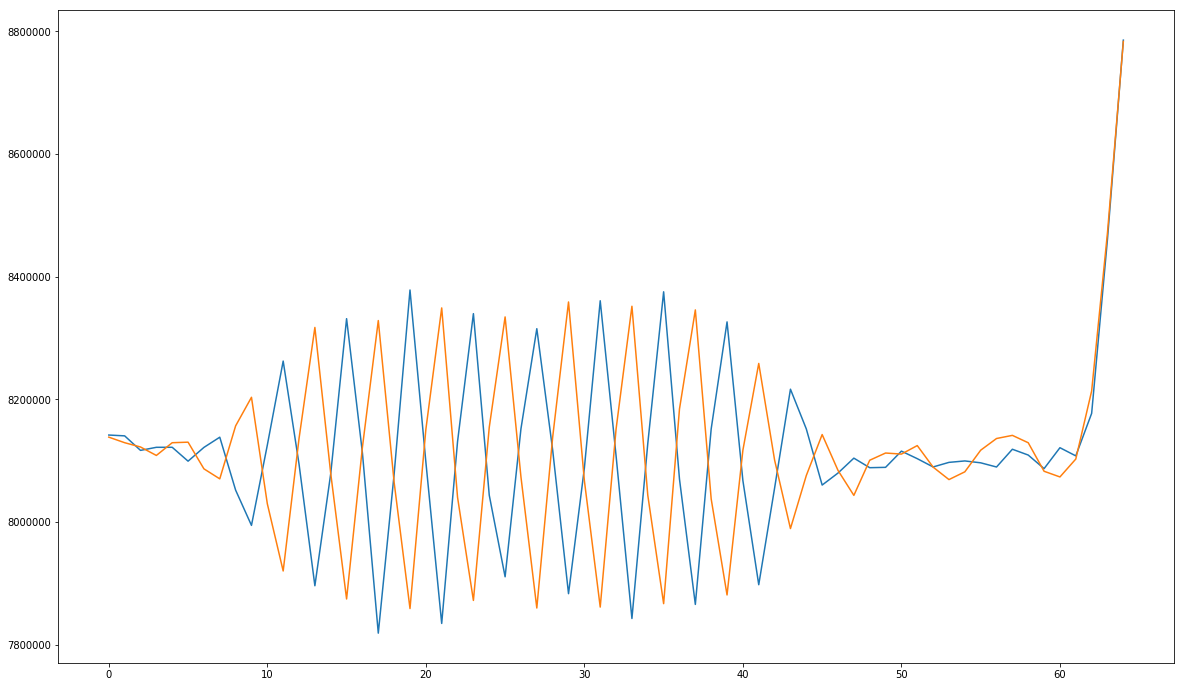

In [137]:
l = 50
x = lines[(910*l)+5:(910*l)+70]
plt.plot(x)
y = lines[(910*(l+1))+5:(910*(l+1))+70]
plt.plot(y)

22.0131165809


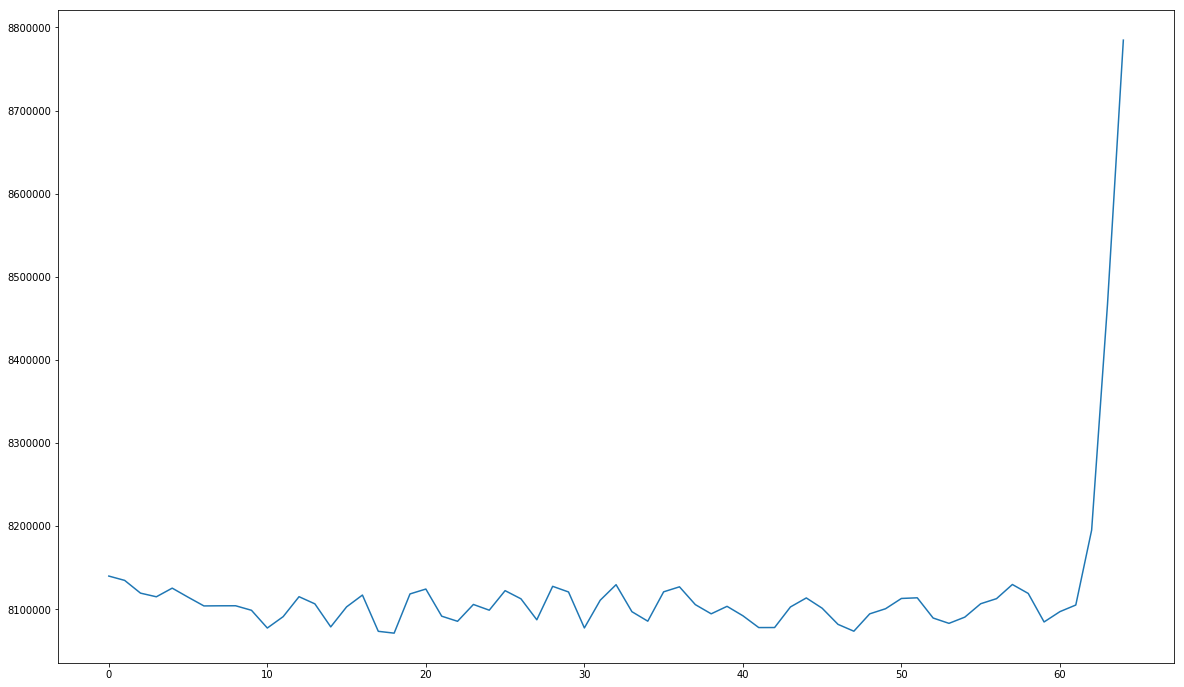

In [138]:
l = 50
x = lines[(910*l)+5:(910*l)+70] + lines[(910*(l+1))+5:(910*(l+1))+70]
plt.plot(x / 2)
calcsnr(x / 2)

(230230,)
uint8 (253, 910) (253, 910)


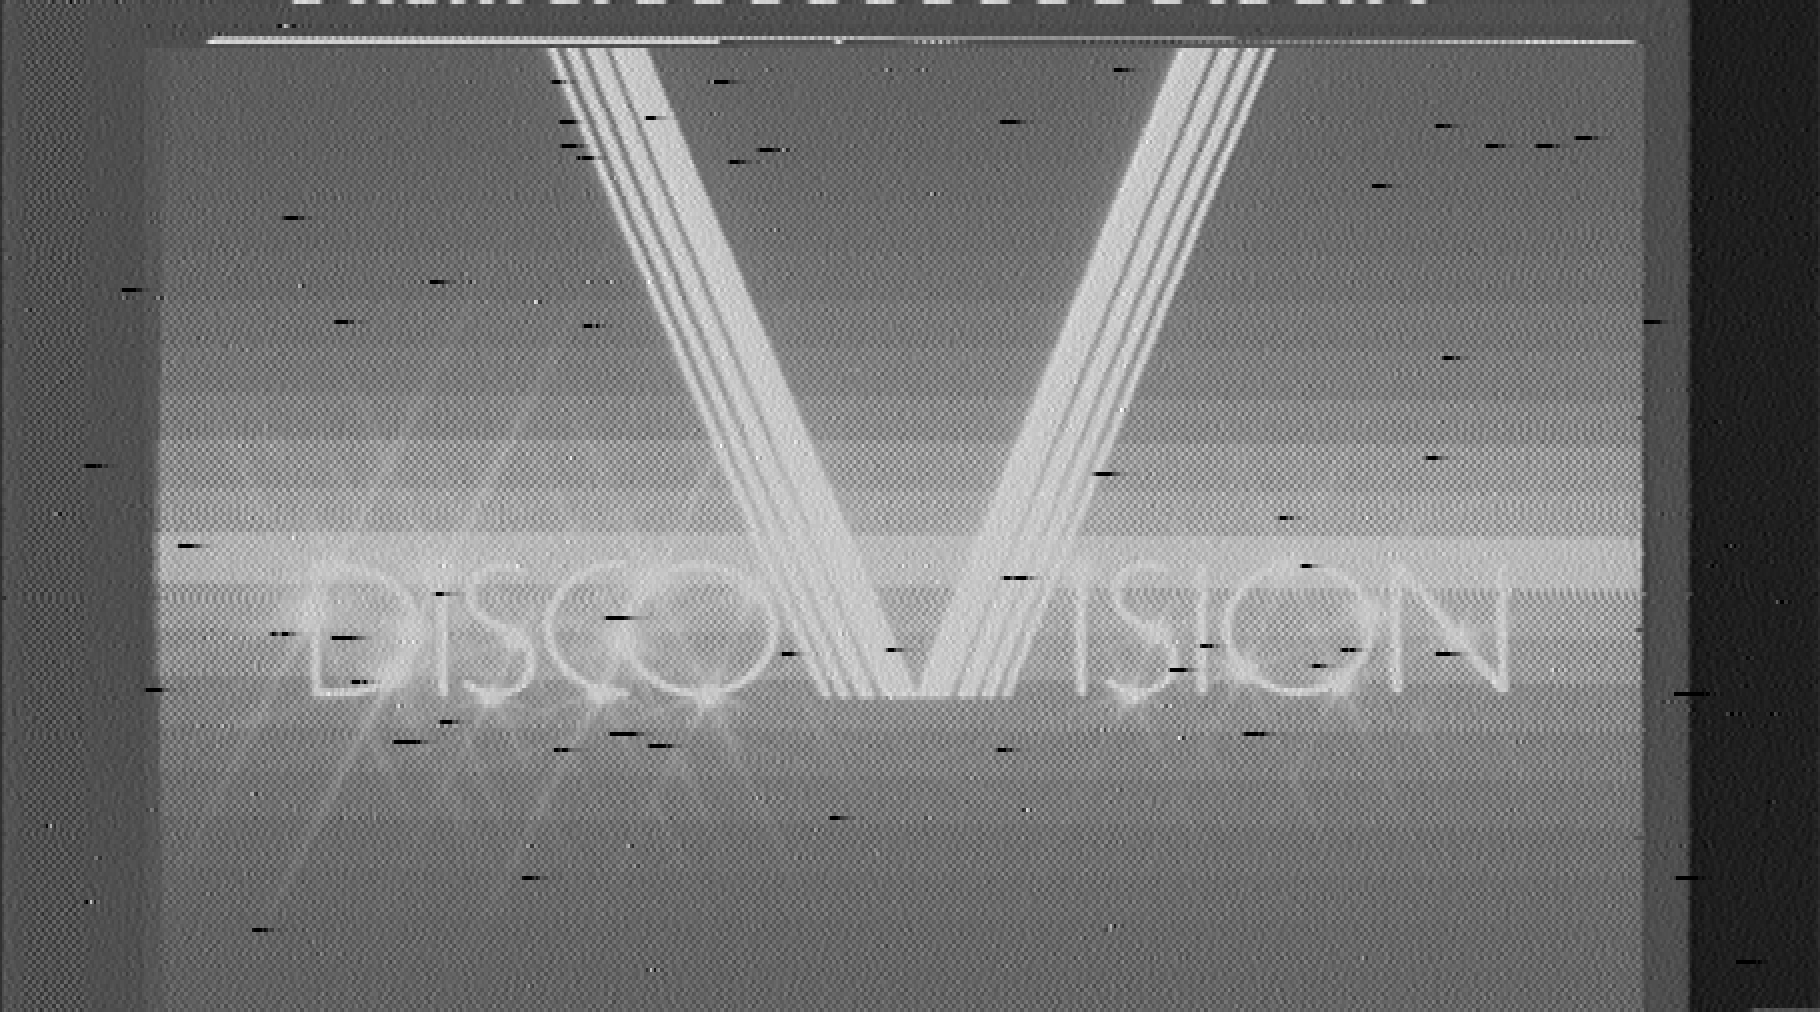

In [35]:
# Example of this code on a rotter :)
reduced = (lines - minn) / hz_ire_scale
lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

drawdata(lines16, 910, len(lineinfo2)-1, hscale=2, vscale=4)

In [36]:
# figure out where vsync is supposed to begin, assuming line start at ire -20:

In [37]:
910/63.5, 58.5*(910/63.5)

(14.330708661417322, 838.3464566929133)

In [38]:
begline = []
endline = []
for l in range(0, len(lineinfo_cur) - 1):
    cline = lines[l * 910:(l + 1) * 910]
    begline.append(calczc(cline, 0, 8000000, 5))
    endline.append(calczc(cline, 840, m20ire, 20))
    if (begline[-1] is None):
        print("b", l)
        begline[-1] = -1
    if (endline[-1] is None):
        print("e", l)
        endline[-1] = 844.25

e 173
e 219


In [39]:
np.min(begline), np.max(begline), np.mean(begline), np.argmax(begline), np.std(begline)

(0.36511998949632013,
 2.7357543924367347,
 0.76349998963594301,
 149,
 0.25001621551811237)

In [40]:
np.min(endline), np.max(endline), np.mean(endline), np.argmax(endline), np.std(endline)

(840.20959013105346,
 845.70162781330214,
 844.23547566598813,
 148,
 0.44573642405298891)

In [41]:
linegaps2 = np.diff(lineinfo2)
linegaps_end = np.diff(lineinfo_cur)

In [42]:
np.mean(linegaps2), np.std(linegaps2), np.min(linegaps2), np.max(linegaps2)

(2794.1198310133477,
 2.2242912880402335,
 2786.4846006617881,
 2799.5613464718917)

In [43]:
np.mean(linegaps_end), np.std(linegaps_end), np.min(linegaps_end), np.max(linegaps_end)

(2794.1198310133477,
 2.2716834575987628,
 2786.4032574766316,
 2800.2662368090241)

In [44]:
filterset['line_px']

2794.0

In [45]:
lineinfo2[147] - lineinfo2[146], lineinfo_cur[147] - lineinfo_cur[146]

(2792.3583034544718, 2792.7066011009738)

In [46]:
lineinfo2[120] - lineinfo2[119], lineinfo_cur[120] - lineinfo_cur[119]

(2791.6145233304705, 2792.2245435791556)

In [47]:
endline[147]

844.04832559894965

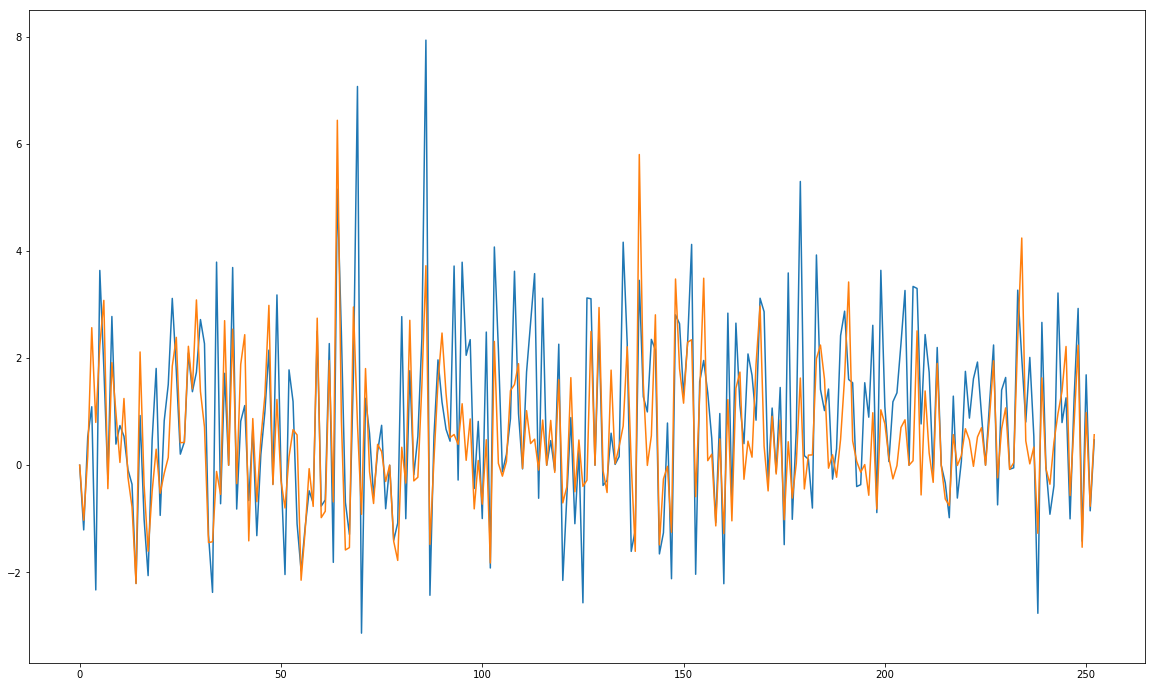

In [48]:
plt.plot(errs[0])
plt.plot(errs[-1])

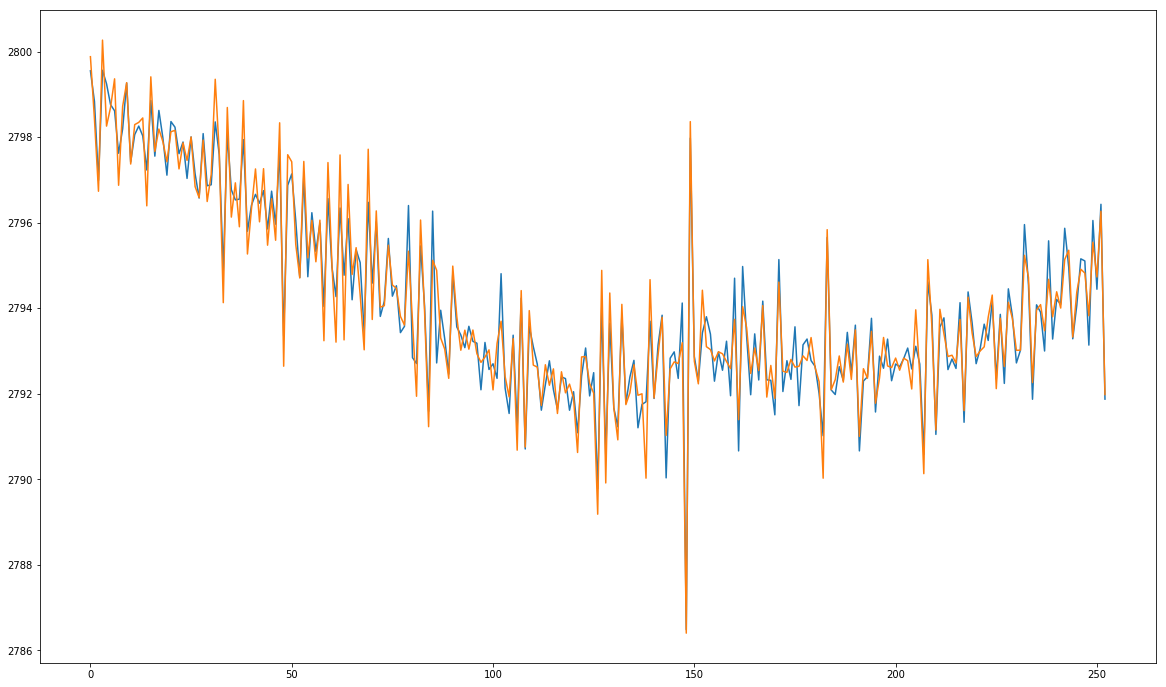

In [49]:
plt.plot(np.diff(lineinfo2))
plt.plot(np.diff(lineinfo_cur))